Some of the code is reused from @Yassinghouzam. Check it out and consider upvoting his notebook! https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
import pickle

In [2]:
df = pd.read_csv("../input/phishing-website-dataset/dataset.csv")

In [3]:
df.shape

(11055, 32)

In [4]:
df['Abnormal_URL'].value_counts()

 1    9426
-1    1629
Name: Abnormal_URL, dtype: int64

In [5]:
display(df.head())

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [6]:
df.drop('index', axis = 1, inplace = True)

## Exploration

The percentages of the class values.

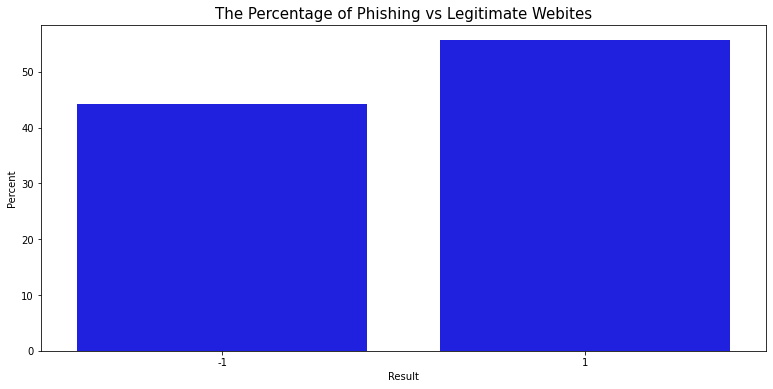

In [7]:
plt.figure(figsize=(13, 6))
ax = sns.barplot(x="Result", y="Result", data=df, estimator=lambda x: len(x) / len(df) * 100, color = 'Blue')
ax.set(ylabel="Percent");
ax.set_title('The Percentage of Phishing vs Legitimate Webites', size = 15);
plt.savefig('resultpercentageplot.png', dpi=300, bbox_inches='tight');

Correlation between all the variables.

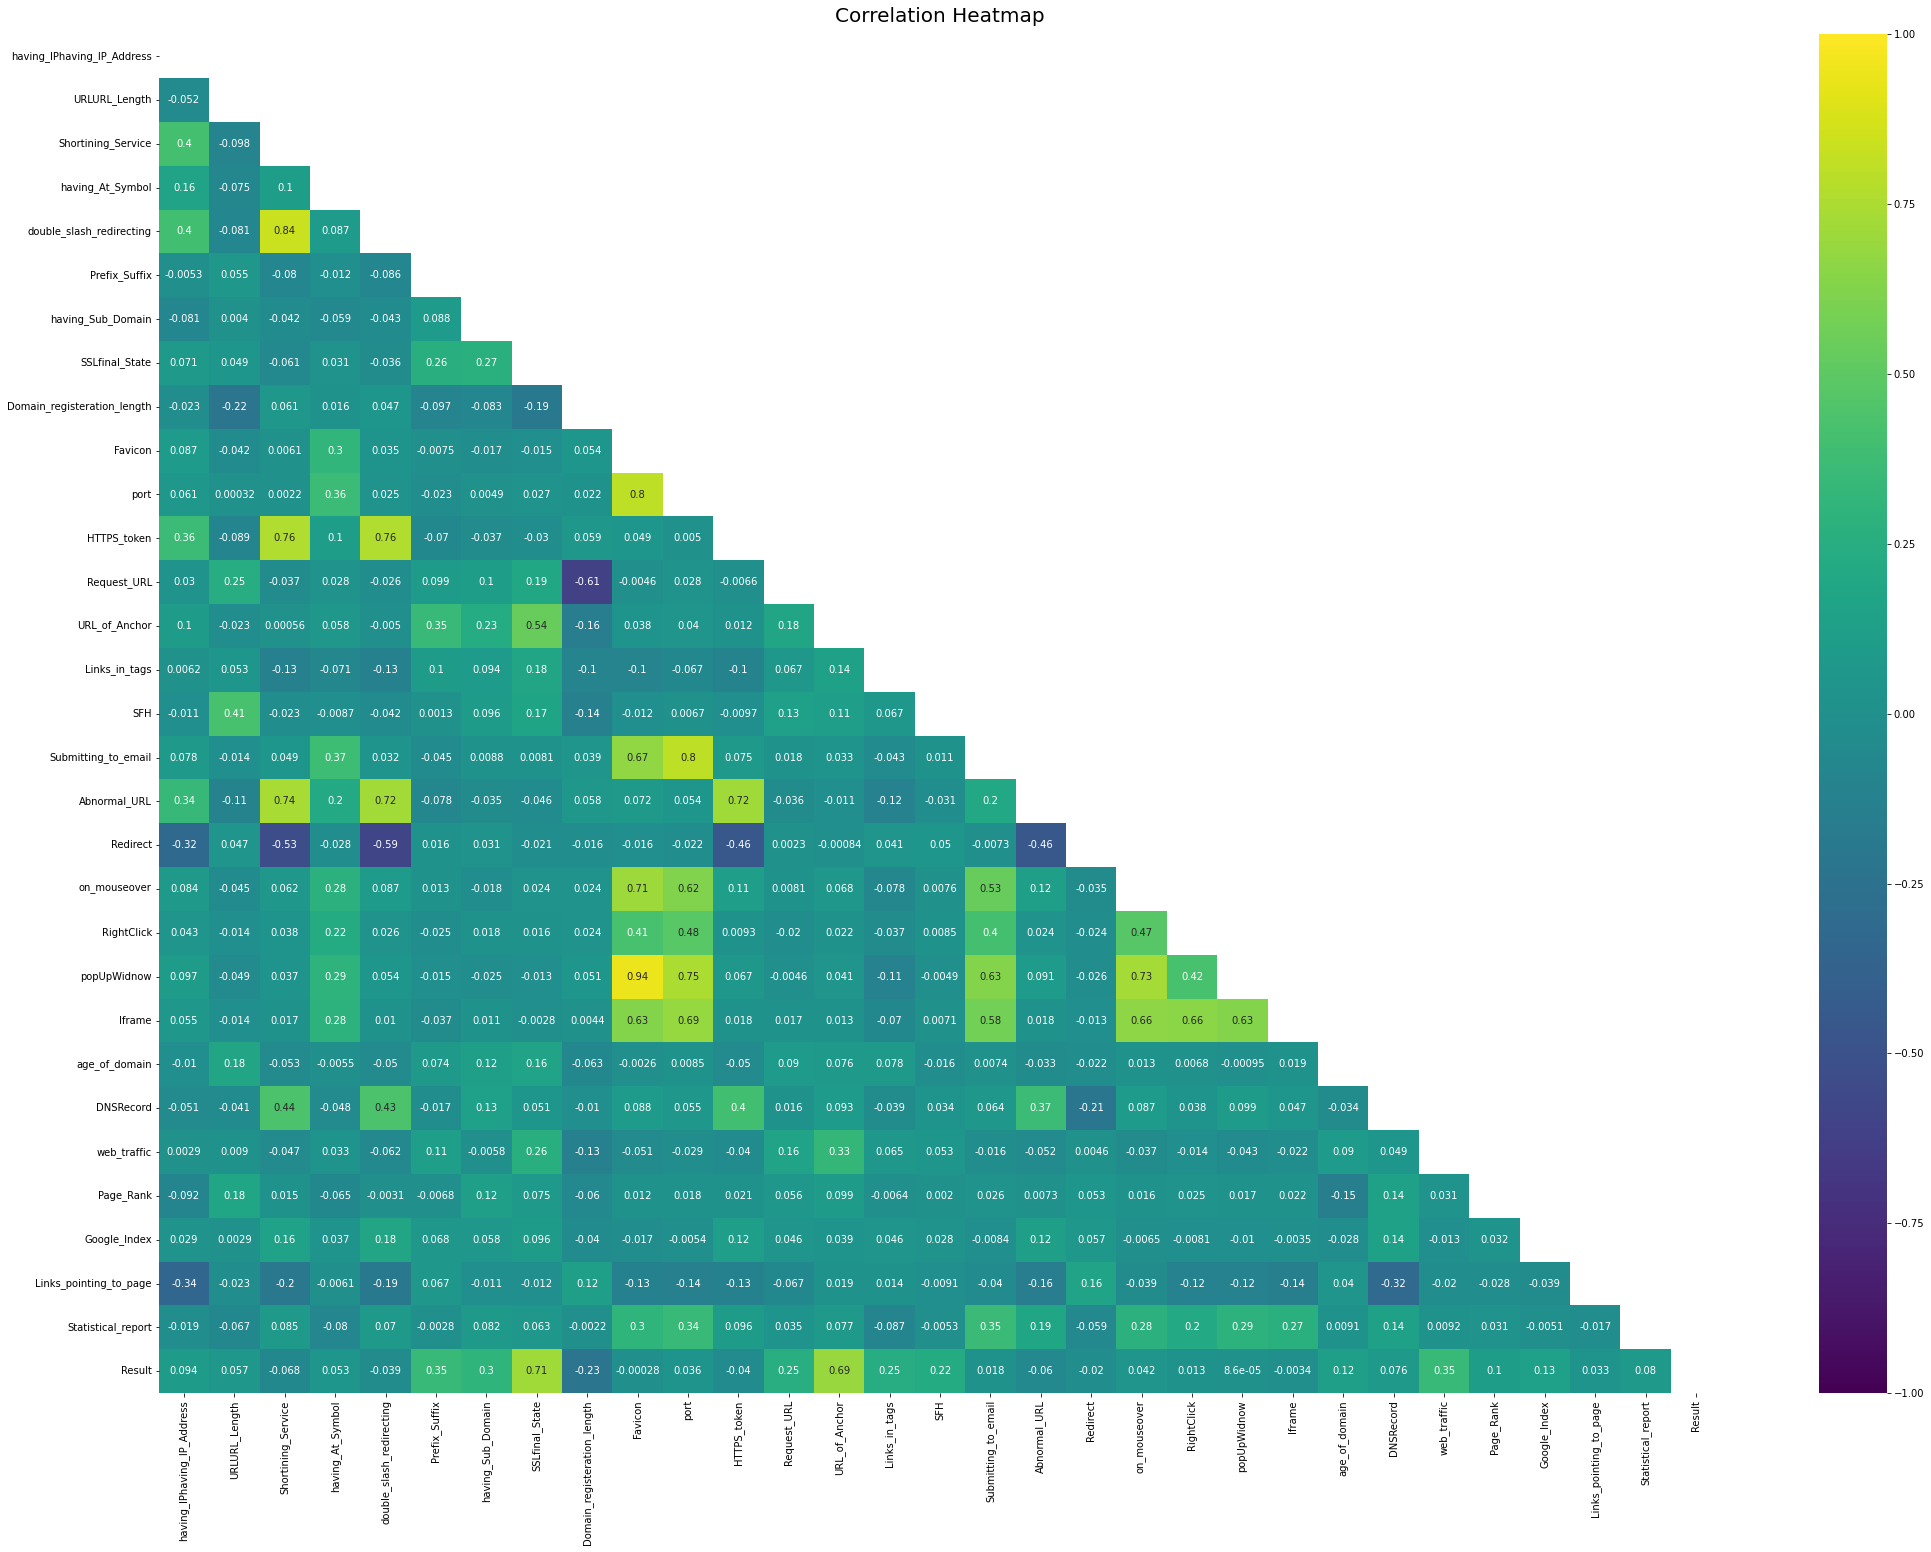

In [8]:
plt.figure(figsize=(35, 25))
corr = df.corr()
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(corr, mask = mask, vmin=-1, vmax=1, annot=True, cmap = 'viridis')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

Variables with the highest correlation with the target variable.

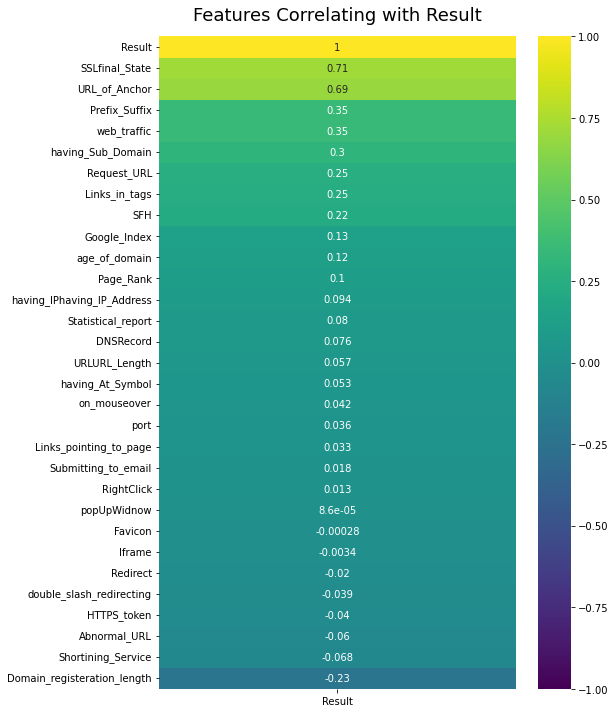

In [9]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['Result']].sort_values(by='Result', ascending=False), vmin=-1, vmax=1, annot=True, cmap = 'viridis')
heatmap.set_title('Features Correlating with Result', fontdict={'fontsize':18}, pad=16);
plt.savefig('heatmapfeaturecorr.png', dpi=300, bbox_inches='tight')

## Ensembling Model

In [10]:
#Splitting Data
X = df.drop('Result', axis = 1)
y = df['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Cross Validate Models

We will compare 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.



* SVC
* Decision Tree
* AdaBoost
* XGBoost
* Random Forest
* Extra Trees
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis


In [11]:
kfold = StratifiedKFold(n_splits=10)

In [12]:
random_state = 42

classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

In [13]:
cv_res.sort_values(by = 'CrossValMeans', ascending = False)
# from the following we'll choose RandomForest, ExtraTrees, NN, AdaBoost and decusion trees as our classifiers.

,CrossValMeans,CrossValerrors,Algorithm
3,0.971644,0.006727,RandomForest
4,0.970563,0.007782,ExtraTrees
6,0.966514,0.006524,MultipleLayerPerceptron
2,0.960301,0.007384,AdaBoost
1,0.956385,0.004848,DecisionTree
5,0.946803,0.008312,GradientBoosting
0,0.946803,0.005837,SVC
7,0.937212,0.007434,KNeighboors
8,0.929250,0.007638,LogisticRegression
9,0.921552,0.006087,LinearDiscriminantAnalysis


### Cross validation on the choosen models best parameters

In [14]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {
              "max_features": [3, 10, 20],
              "n_estimators" :[100,300, 500],
              "criterion": ["gini", "entropy"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   38.7s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  4.1min finished


0.9731281686544844

In [15]:
gsRFC.best_params_

{'criterion': 'gini', 'max_features': 3, 'n_estimators': 500}

In [16]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "n_estimators" :[100,300, 400],
              "criterion": ["gini", "entropy"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  8.7min finished


0.9720489112594377

In [17]:
gsExtC.best_params_

{'criterion': 'entropy',
 'max_features': 1,
 'min_samples_split': 3,
 'n_estimators': 300}

In [18]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[10, 50, 100, 150],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_
print(gsadaDTC.best_score_)

Fitting 10 folds for each of 224 candidates, totalling 2240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 12.0min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 18.8min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 27.6min
[Parallel(n_jobs=4)]: Done 2240 out of 2240 | elapsed: 34.9min finished


0.9715091001933107


In [19]:
gsadaDTC.best_params_

{'algorithm': 'SAMME.R',
 'base_estimator__criterion': 'entropy',
 'base_estimator__splitter': 'random',
 'learning_rate': 0.2,
 'n_estimators': 150}

In [20]:
# # Multilayer Neural Network
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(300,200,100), (200,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(300, 200, 100),
                                                (200, 100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [21]:
clf.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (200, 100, 50),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [22]:
clf.best_score_

0.9674590699467205

In [23]:
nn_best = clf.best_estimator_

In [24]:
# Decision Tree
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : range(1,50),
              'min_samples_split': range(2,15),
              'min_samples_leaf': range(1,10),
              'criterion' :['gini', 'entropy']
             }

tree_clas = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, verbose=True)
grid_search.fit(X_train, y_train)

dt_best = grid_search.best_estimator_

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 34398 candidates, totalling 171990 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached a

{'criterion': 'entropy', 'max_depth': 23, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
0.9512556256896852


### Plot learning curves

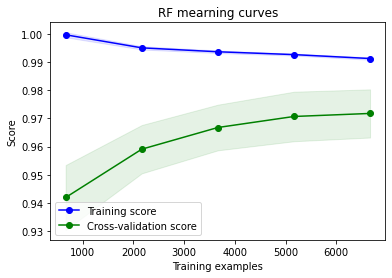

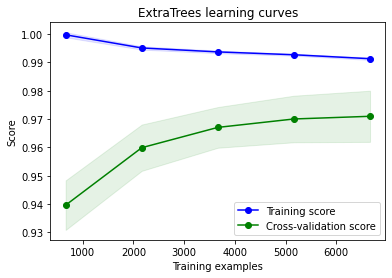

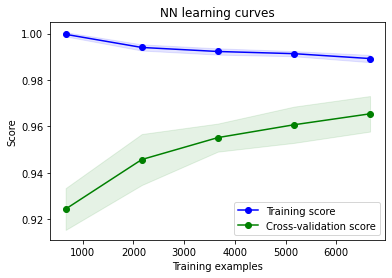

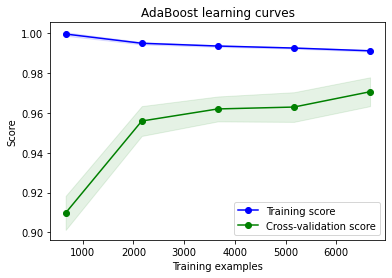

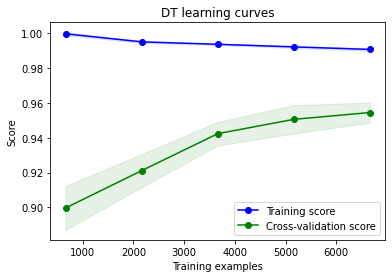

In [25]:
def plot_learning_curve(estimator, title, X, y, save, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    #plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig(save, dpi=300, bbox_inches='tight')
    return plt

g1 = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold, save = 'RFLearningPlot')
g2 = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold, save = 'ETLearningPlot')
g3 = plot_learning_curve(nn_best,"NN learning curves",X_train,y_train,cv=kfold, save = 'NNLearningPlot')
g4 = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold, save = 'AdaLearningPlot')
g5 = plot_learning_curve(dt_best,"DT learning curves",X_train,y_train,cv=kfold, save = 'DTLearningPlot')

Decision tree had the highest tendency to overfit.

### Voting Classifier

In [26]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('nn', nn_best), ('adac',ada_best),('dt',dt_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, y_train)
y_pred = votingC.predict(X_test)

pickle.dump(votingC, open('model.sav', 'wb'))

# to read the model later
# model = pickle.load(open('model', 'rb'))
# res = model.score(X_test, y_test)
# res

### Plot Confusion Matrix

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9671142778843519

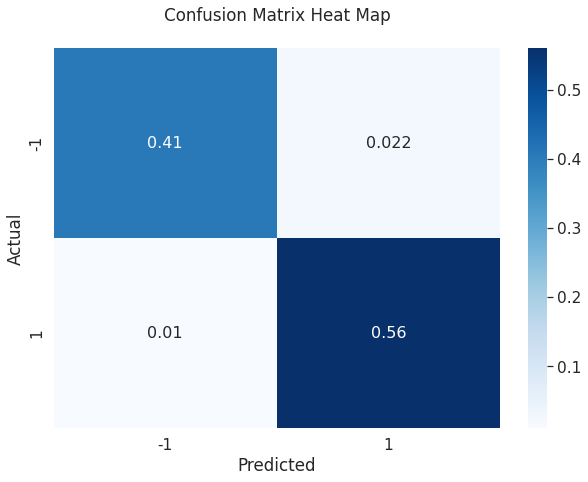

In [28]:
data = confusion_matrix(y_test, y_pred, normalize = 'all')
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.title("Confusion Matrix Heat Map\n")
plt.savefig('ConfusionMatrix', dpi=300, bbox_inches='tight')

In [29]:
print(f'{votingC} Training Score: {votingC.score(X_train, y_train)}')
print(f'{votingC} Testing Score: {votingC.score(X_test, y_test)}')
print()
print(classification_report(y_test, y_pred))
#print(confusion_matrix(y_test, y_pred))

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(max_features=3,
                                                     n_estimators=500)),
                             ('extc',
                              ExtraTreesClassifier(criterion='entropy',
                                                   max_features=1,
                                                   min_samples_split=3,
                                                   n_estimators=300)),
                             ('nn',
                              MLPClassifier(hidden_layer_sizes=(200, 100, 50),
                                            learning_rate='adaptive',
                                            max_iter=100)),
                             ('adac',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                       splitter='random'),
   

In [30]:
target_names = ['Phishing', 'Legitamite']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Phishing       0.98      0.95      0.96      1565
  Legitamite       0.96      0.98      0.97      2084

    accuracy                           0.97      3649
   macro avg       0.97      0.96      0.97      3649
weighted avg       0.97      0.97      0.97      3649

